In [25]:
import numpy as np
import pandas as pd

import seaborn as sns  
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.sans-serif"]=["SimHei"]#展示中文字体
mpl.rcParams["axes.unicode_minus"]=False#处理负刻度值

In [26]:
data_raw = pd.read_excel("data/附件1-商家历史出货量表.xlsx")

In [27]:
product_type_raw = pd.read_excel("data/附件2-商品信息表.xlsx")
storage_type_raw = pd.read_excel("data/附件4-仓库信息表.xlsx")
seller_type_raw = pd.read_excel("data/附件3-商家信息表.xlsx")
seller_type_raw.head()

,seller_no,seller_category,inventory_category,seller_level
0,seller_1,居家生活,B,New
1,seller_2,厨具,A,Large
2,seller_3,厨具,A,Large
3,seller_4,家居日用,A,Large
4,seller_5,家居日用,B,Large


In [28]:
data = data_raw
data.head()

,seller_no,product_no,warehouse_no,date,qty
0,seller_19,product_448,wh_30,2023-05-09,10
1,seller_19,product_448,wh_30,2023-04-17,14
2,seller_19,product_448,wh_30,2023-01-09,2
3,seller_19,product_448,wh_30,2023-01-20,1
4,seller_19,product_448,wh_30,2023-02-13,22


In [29]:
product_type = product_type_raw.set_index("product_no")
storage_type = storage_type_raw.drop_duplicates(keep='first').set_index("warehouse_no")
seller_type = seller_type_raw.set_index("seller_no")
seller_type["mixed type"] = seller_type["inventory_category"]+" "+seller_type["seller_level"]
seller_type.head()

,seller_category,inventory_category,seller_level,mixed type
seller_no,,,,
seller_1,居家生活,B,New,B New
seller_2,厨具,A,Large,A Large
seller_3,厨具,A,Large,A Large
seller_4,家居日用,A,Large,A Large
seller_5,家居日用,B,Large,B Large


- 仓库数据中wh_29、wh_38数据重复，只保留一个

# 数据分类

- 根据商品类型分类
- 根据地区分类
- 根据商家体量分类
- 根据变化趋势分类

In [30]:
product = data.set_index("product_no")[["warehouse_no","date","qty"]]
product.head()

,warehouse_no,date,qty
product_no,,,
product_448,wh_30,2023-05-09,10
product_448,wh_30,2023-04-17,14
product_448,wh_30,2023-01-09,2
product_448,wh_30,2023-01-20,1
product_448,wh_30,2023-02-13,22


In [31]:
product["type"] = product_type.loc[product.index]["category1"]
product["region"] = storage_type.loc[product["warehouse_no"]]["warehouse _region"].values
product.head()

,warehouse_no,date,qty,type,region
product_no,,,,,
product_448,wh_30,2023-05-09,10,手机通讯,华南
product_448,wh_30,2023-04-17,14,手机通讯,华南
product_448,wh_30,2023-01-09,2,手机通讯,华南
product_448,wh_30,2023-01-20,1,手机通讯,华南
product_448,wh_30,2023-02-13,22,手机通讯,华南


In [32]:
import random
def aver_corr(matrix):
    s = matrix.values.sum() - len(matrix)
    
    return s/len(matrix)/(len(matrix)-1)

## 随机对照

In [33]:
count = 50
categ = 10

index_labels = product.index.values.copy()
random.shuffle(index_labels)

grouped_index = [index_labels[i:i + count] for i in range(0, categ*count, count)]

In [34]:
name = []
random_corr = []

grouped_dfs = (product.loc[group] for group in grouped_index)

for i, df in enumerate(grouped_dfs):
    name += [i]
    df = df.groupby(["product_no","date"]).mean().unstack(level=0).fillna(0)
    
    random_corr += [aver_corr(df.corr())]

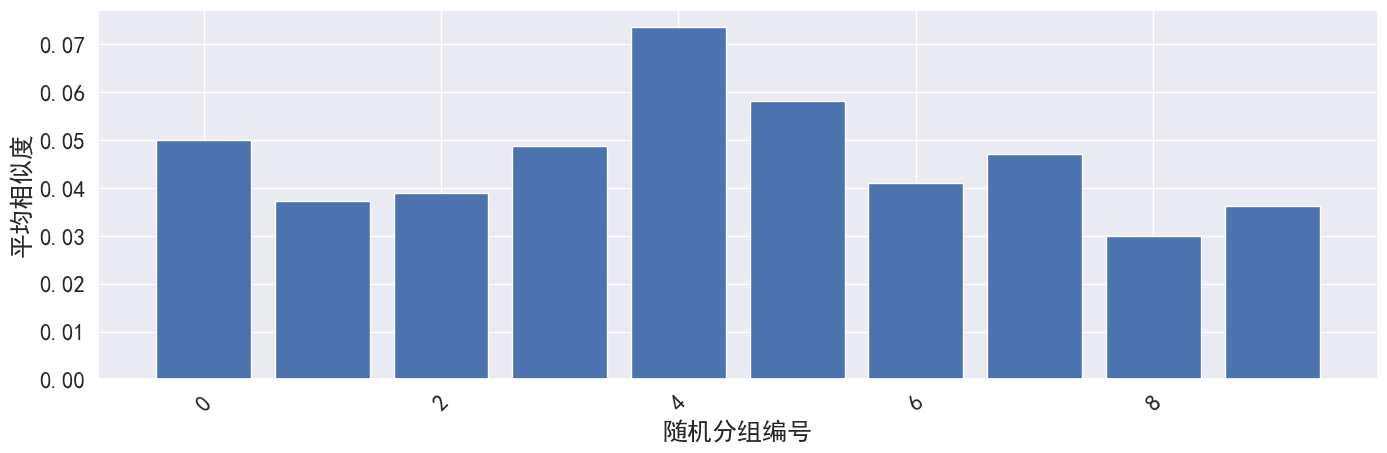

In [35]:
plt.bar(name, random_corr)

plt.xticks(rotation=45)

plt.ylabel('平均相似度')
plt.xlabel('随机分组编号')

plt.subplots_adjust(left=0, right=2)
plt.show()

## 商品类型 

In [36]:
import random
count = 50
name = []
type_corr = []

for idx, df in product.groupby("type"):

    qtys = df.groupby(["product_no","date"]).mean()
    qtys = qtys.unstack(level=0).fillna(0)
    
    clist = qtys.columns.tolist()
    rand_colm = random.sample(clist, min(count, len(clist)))
    
    name += [idx]
    type_corr += [aver_corr(qtys[rand_colm].corr())]

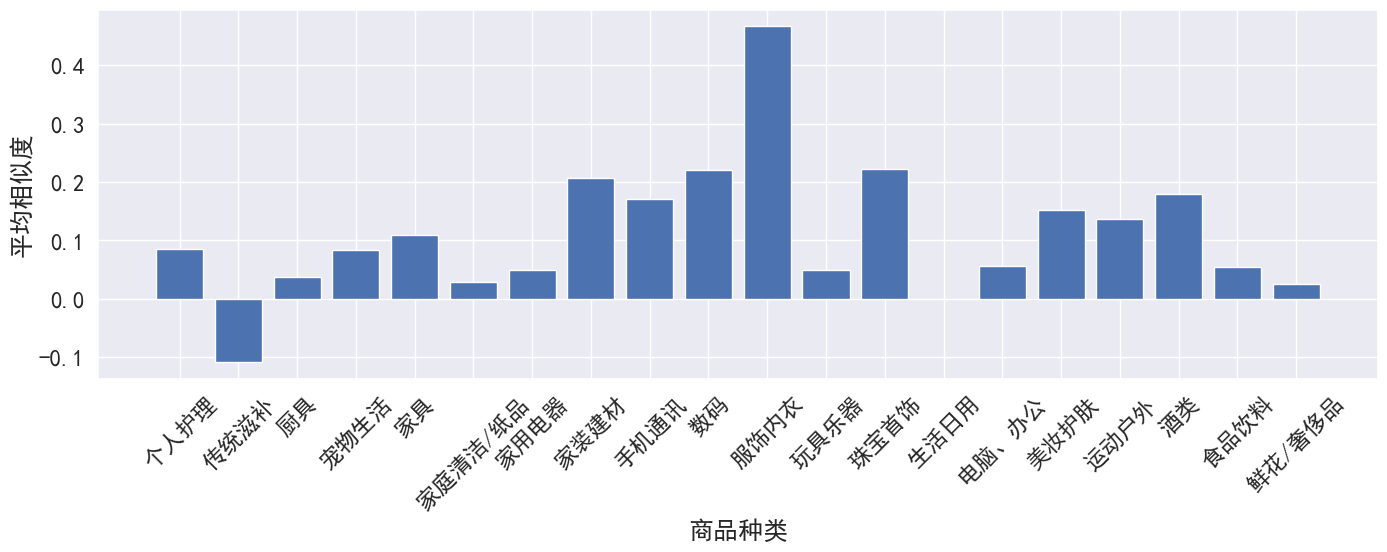

In [37]:
plt.bar(name, type_corr)

plt.xticks(rotation=45)

plt.ylabel('平均相似度')
plt.xlabel('商品种类')

plt.subplots_adjust(left=0, right=2)
plt.show()

## 地区 

In [38]:
count = 50

name = []
region_corr = []

for idx, df in product.groupby("region"):

    qtys = df.groupby(["product_no","date"]).mean()
    qtys = qtys.unstack(level=0).fillna(0)
    
    clist = qtys.columns.tolist()
    rand_colm = random.sample(clist, min(count, len(clist)))
    
    name += [idx]
    region_corr += [aver_corr(qtys[rand_colm].corr())]

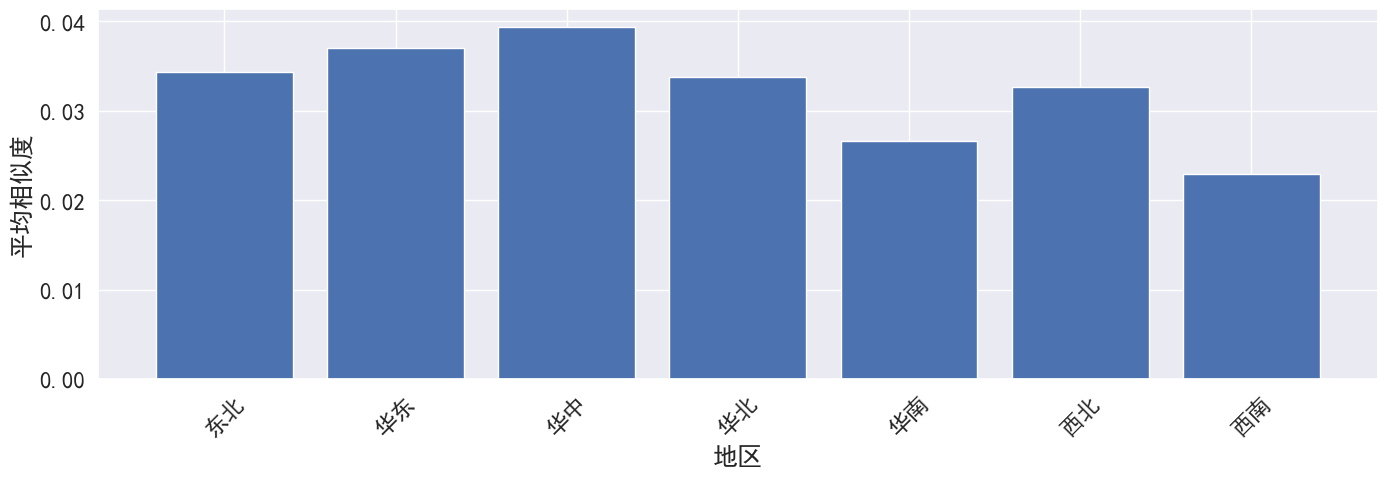

In [39]:
plt.bar(name, region_corr)

plt.xticks(rotation=45)

plt.ylabel('平均相似度')
plt.xlabel('地区')

plt.subplots_adjust(left=0, right=2)
plt.show()

## 商家体量

In [40]:
product_seller = data.set_index("product_no")[["seller_no","date","qty"]]
product_seller["seller t"] = seller_type.loc[product_seller["seller_no"]]["mixed type"].values
product_seller.head()
#seller_type.loc[product_seller["seller_no"]]["mixed type"]

,seller_no,date,qty,seller t
product_no,,,,
product_448,seller_19,2023-05-09,10,C Large
product_448,seller_19,2023-04-17,14,C Large
product_448,seller_19,2023-01-09,2,C Large
product_448,seller_19,2023-01-20,1,C Large
product_448,seller_19,2023-02-13,22,C Large


In [41]:
count = 50

name = []
seller_corr = []

for idx, df in product_seller.groupby("seller t"):

    qtys = df.groupby(["product_no","date"]).mean()
    qtys = qtys.unstack(level=0).fillna(0)
    
    clist = qtys.columns.tolist()
    rand_colm = random.sample(clist, min(count, len(clist)))
    
    name += [idx]
    seller_corr += [aver_corr(qtys[rand_colm].corr())]

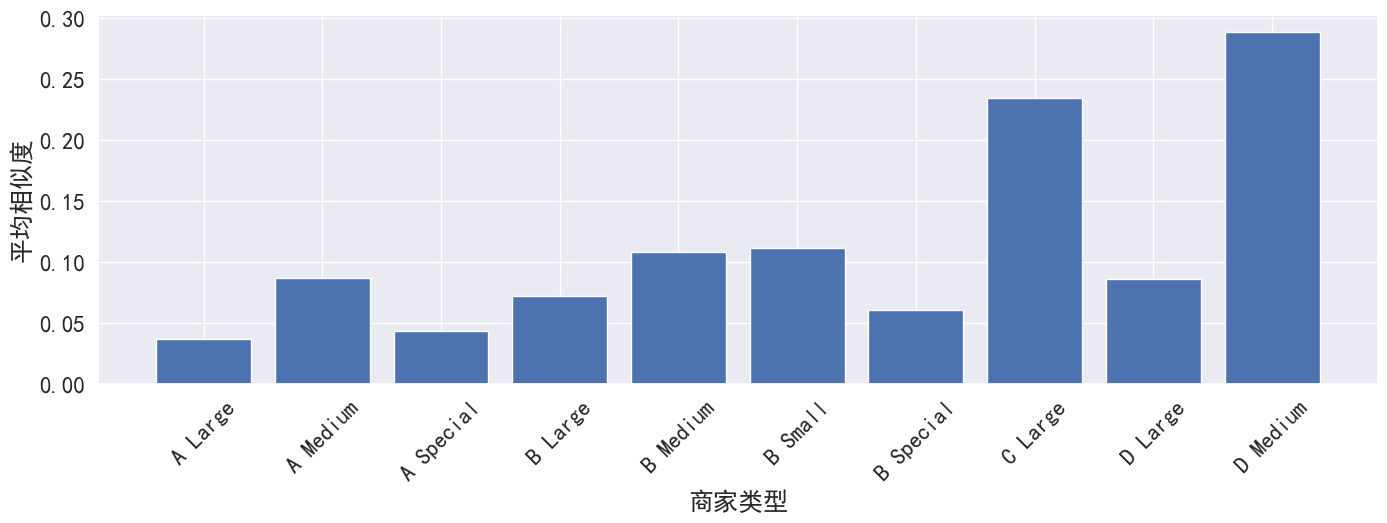

In [42]:
plt.bar(name, seller_corr)

plt.xticks(rotation=45)

plt.ylabel('平均相似度')
plt.xlabel('商家类型')

plt.subplots_adjust(left=0, right=2)
plt.show()

## 随机性&平稳性分类 

In [19]:
product_stat = product[["warehouse_no","date","qty"]].groupby(["product_no","date"]).mean().reset_index("date")
product_stat

,date,qty
product_no,,
product_1001,2022-12-01,13.333333
product_1001,2022-12-02,11.000000
product_1001,2022-12-03,11.666667
product_1001,2022-12-04,9.666667
product_1001,2022-12-05,8.000000
...,...,...
product_998,2023-05-11,78.000000
product_998,2023-05-12,73.500000
product_998,2023-05-13,75.000000


In [20]:
from statsmodels.tsa.stattools import adfuller
min_p = 0.05

#product_stat["station"] = False
for idx, df in product_stat.groupby("product_no"):
    product_stat.loc[idx, "station"] = adfuller(df["qty"])[1]<min_p
    
product_stat[product_stat["station"]]

D:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


,date,qty,station
product_no,,,
product_1005,2022-12-01,1.666667,True
product_1005,2022-12-02,2.666667,True
product_1005,2022-12-03,1.333333,True
product_1005,2022-12-04,0.000000,True
product_1005,2022-12-05,1.000000,True
...,...,...,...
product_995,2023-05-11,10.000000,True
product_995,2023-05-12,10.000000,True
product_995,2023-05-13,13.000000,True


In [21]:
#product_stat["station"] = False
for idx, df in product_stat.groupby("product_no"):
    product_stat.loc[idx, "std"] = df["qty"].std()
    
product_stat["over std"] = product_stat["std"]>product_stat["std"].mean()
product_stat

,date,qty,station,std,over std
product_no,,,,,
product_1001,2022-12-01,13.333333,False,51.502254,True
product_1001,2022-12-02,11.000000,False,51.502254,True
product_1001,2022-12-03,11.666667,False,51.502254,True
product_1001,2022-12-04,9.666667,False,51.502254,True
product_1001,2022-12-05,8.000000,False,51.502254,True
...,...,...,...,...,...
product_998,2023-05-11,78.000000,False,23.004306,True
product_998,2023-05-12,73.500000,False,23.004306,True
product_998,2023-05-13,75.000000,False,23.004306,True


In [44]:
count = 100

name = []
propert_corr = []

for idx, df in product_stat.groupby(["station", "over std"]):
    df = df.reset_index()[["product_no","date", "qty"]].set_index(["product_no","date"])

    qtys = df.unstack(level=0).fillna(0)
    
    clist = qtys.columns.tolist()
    rand_colm = random.sample(clist, min(count, len(clist)))

    name += [str(idx)]
    propert_corr += [aver_corr(qtys[rand_colm].corr())]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


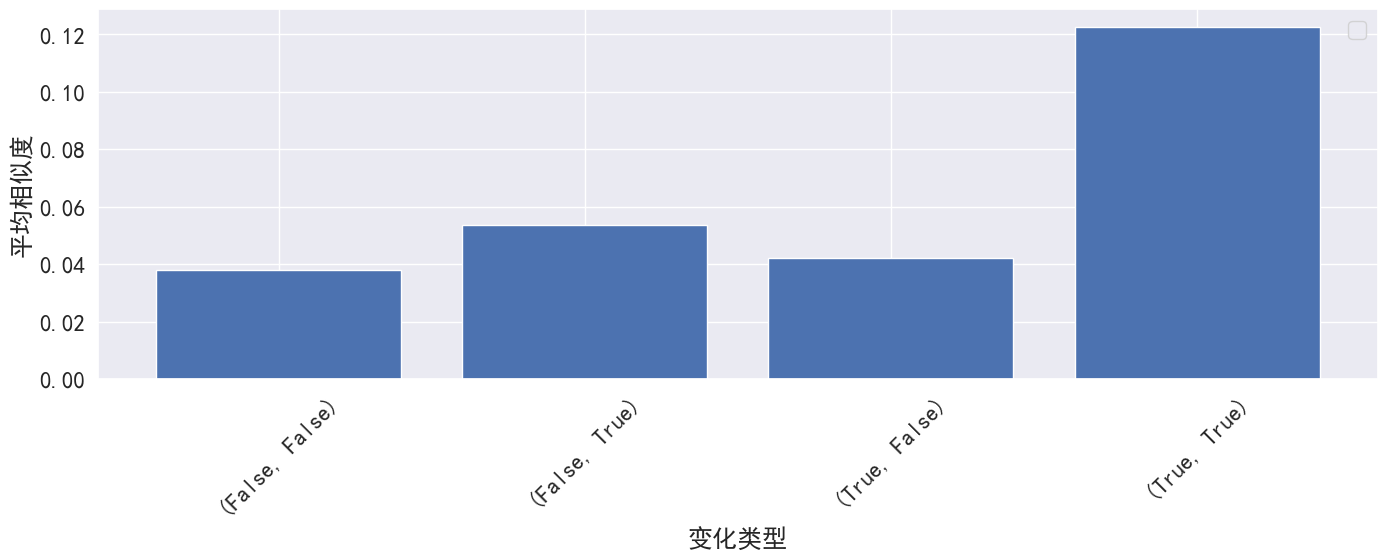

In [45]:
plt.bar(name, propert_corr)

plt.xticks(rotation=45)

plt.ylabel('平均相似度')
plt.xlabel('变化类型')

plt.legend()
plt.subplots_adjust(left=0, right=2)
plt.show()

In [24]:
import numpy as np
a = np.array([1.1,2.2,3.3])
a.round()

array([1., 2., 3.])